In [1]:
from models import *
from utils import set_seed
from data.loaders import *
from utils import *

In [5]:
user = 'ajimenez'
path_to_model = f"/home/{user}/CoSE-pytorch/wandb/latest-run/files/3o829j1g_weights_trained/epoch_108"

In [6]:
config = configure_model('config.json', False)

In [7]:
set_seed(0)
device = torch.device('cuda:2')
cose = CoSEModel(config, False)
cose.encoder.load_state_dict(torch.load(os.path.join(os.getcwd(), path_to_model,"encoder.pth"), map_location=device))
cose.decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model ,"decoder.pth"), map_location=device))
cose.position_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"pos_pred.pth"), map_location=device))
cose.embedding_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"emb_pred.pth"), map_location=device))

<All keys matched successfully>

In [8]:
#optimizer_ae, optimizer_pos_pred, optimizer_emb_pred 
#optimizers = cose.init_optimizers()

train_loader = get_batch_iterator(cose.config.train_dataset_path)

log_dir = f'/home/ajimenez/pruebas'

In [9]:
mean_channel, std_channel = get_stats(cose.config.stats_path)

In [10]:
for batch_input, batch_target in iter(train_loader):
    break

In [11]:
enc_inputs, t_inputs, stroke_len_inputs, inputs_start_coord, inputs_end_coord, num_strokes_x_diagram_tensor = parse_inputs(batch_input,cose.device)
t_target_ink = parse_targets(batch_target,cose.device)

In [12]:
comb_mask , look_ahead_mask, _ = generate_3d_mask(enc_inputs, stroke_len_inputs, cose.device, cose.config.enc_nhead)
encoder_out = cose.encoder(enc_inputs.permute(1,0,2), stroke_len_inputs, comb_mask)
encoder_out_reshaped = encoder_out.unsqueeze(dim=1).repeat(1,t_inputs.shape[1],1).reshape(-1, encoder_out.shape[-1])
t_inputs_reshaped = t_inputs.reshape(-1,1)
decoder_inp = torch.cat([encoder_out_reshaped, t_inputs_reshaped], dim = 1)
strokes_out, ae_mu, ae_sigma, ae_pi= cose.decoder(decoder_inp)

In [13]:
sampled_input_start_pos, sampled_input_emb,sampled_seq_len_emb,sampled_target_start_pos,sampled_target_emb = random_index_sampling(encoder_out = encoder_out, inputs_start_coord = inputs_start_coord,
                                                                                                                                inputs_end_coord = inputs_end_coord, num_strokes_x_diagram_tensor = num_strokes_x_diagram_tensor,
                                                                                                                                input_type =cose.config.input_type, num_predictive_inputs = 32,
                                                                                                                                replace_padding = True, end_positions = False, device = cose.device)

In [14]:
sampled_input_start_pos = sampled_input_start_pos.detach().to(cose.device)
sampled_input_emb = sampled_input_emb.detach().to(cose.device)
sampled_seq_len_emb = sampled_seq_len_emb.detach()
sampled_target_start_pos = sampled_target_start_pos.detach()
sampled_target_emb = sampled_target_emb.detach()

In [15]:
shuffle_rule = torch.randperm(sampled_input_start_pos.size()[0])

In [22]:
sampled_input_start_pos = sampled_input_start_pos[shuffle_rule]
sampled_input_emb = sampled_input_emb[shuffle_rule]
sampled_seq_len_emb = sampled_seq_len_emb[shuffle_rule]
sampled_target_start_pos = sampled_target_start_pos[shuffle_rule]
sampled_target_emb = sampled_target_emb[shuffle_rule]

In [23]:
sampled_seq_len_emb.shape

torch.Size([1024])

In [16]:
from utils.temp import pred_pos_emb

In [17]:
n_diagram = 3

In [18]:
emb_base = sampled_input_emb[n_diagram][:sampled_seq_len_emb[n_diagram].int()].to(cose.device)
base_batch_start_pos = sampled_input_start_pos[n_diagram][:sampled_seq_len_emb[n_diagram].int()].to(cose.device)
base_target_start_pos = sampled_target_start_pos[n_diagram]
base_seq_len = sampled_seq_len_emb[n_diagram].detach().clone()
for i in range(2):
    base_target_start_pos, emb_pred = pred_pos_emb(cose,emb_base.unsqueeze(dim=0), base_batch_start_pos.unsqueeze(dim = 0), base_target_start_pos.unsqueeze(dim = 0), base_seq_len.unsqueeze(dim=0))
    base_batch_start_pos = torch.vstack([base_batch_start_pos,base_target_start_pos])
    base_target_start_pos = base_target_start_pos.squeeze()
    emb_base = torch.vstack([emb_base,emb_pred])
    base_seq_len+=1

In [19]:
base_draw_seq_len = np.array([50]*(emb_base.size(0)))

In [20]:
base_batch_stroke = decode_sequence(cose.decoder, emb_base, base_draw_seq_len, cose.device)

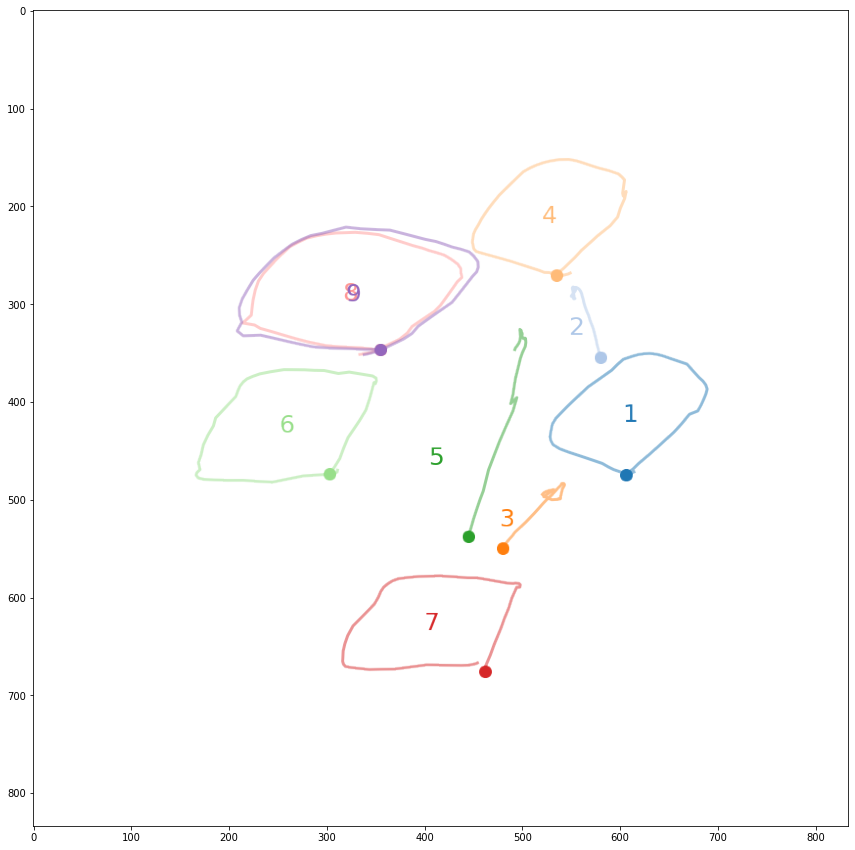

In [21]:
npfig, fig, _, _ = transform_strokes_to_image(base_batch_stroke.detach().cpu(), base_draw_seq_len, base_batch_start_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=base_batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)
plt.figure(figsize = (15,15))
plt.imshow(npfig)

In [20]:
emb_base = sampled_input_emb[n_diagram][:sampled_seq_len_emb[n_diagram].int()].to(cose.device)
base_batch_start_pos = sampled_input_start_pos[n_diagram][:sampled_seq_len_emb[n_diagram].int()].to(cose.device)
base_target_start_pos = sampled_target_start_pos[n_diagram]
base_seq_len = sampled_seq_len_emb[n_diagram]

In [21]:
out_pos_sample, emb_pred = pred_pos_emb(cose,emb_base.unsqueeze(dim=0), base_batch_start_pos.unsqueeze(dim = 0), base_target_start_pos.unsqueeze(dim = 0), base_seq_len.unsqueeze(dim=0))

In [22]:
img_size = (10,10)

In [23]:
#Drawing embeddings in base
base_draw_seq_len = np.array([50]*(emb_base.size(0)))
base_batch_stroke = decode_sequence(cose.decoder, emb_base, base_draw_seq_len, cose.device)

In [24]:
#Drawing predicted embeddings together

In [25]:
predicted_draw_seq_len = np.array([50]*(emb_pred.size(0)))
predicted_batch_stroke = decode_sequence(cose.decoder, emb_pred, predicted_draw_seq_len, cose.device)

In [26]:
batch_start_pos = torch.vstack([base_batch_start_pos,out_pos_sample])
batch_stroke = torch.vstack([base_batch_stroke,predicted_batch_stroke])
draw_seq_len = np.append(base_draw_seq_len, predicted_draw_seq_len)

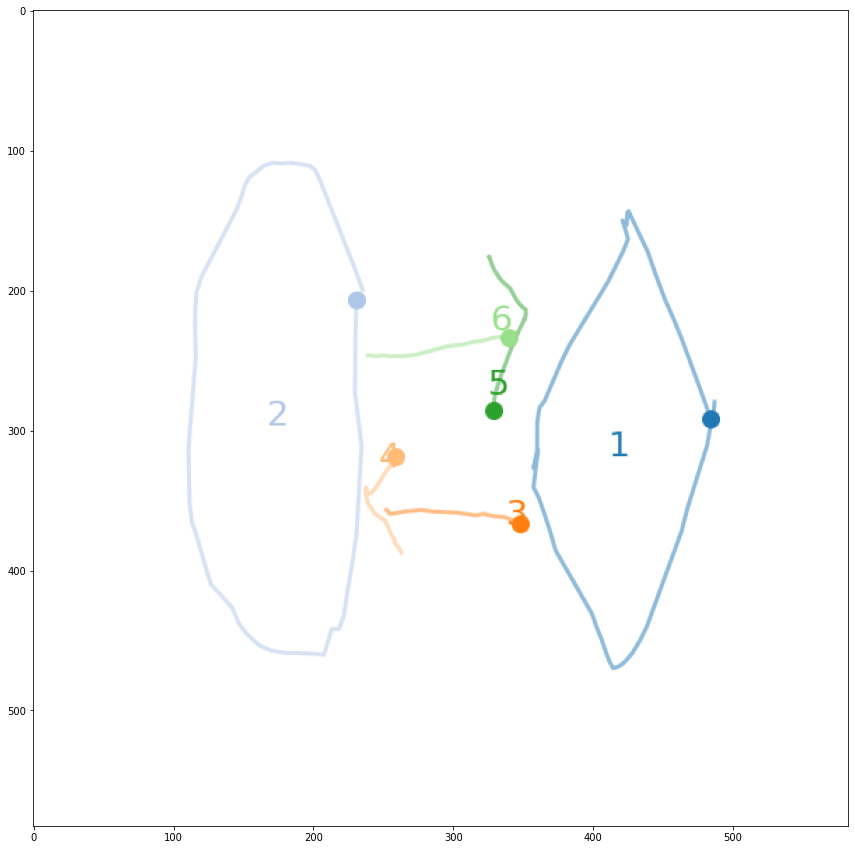

In [27]:
npfig, fig, _, _ = transform_strokes_to_image(base_batch_stroke.detach().cpu(), base_draw_seq_len, base_batch_start_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=base_batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)
plt.figure(figsize = (15,15))
plt.imshow(npfig)

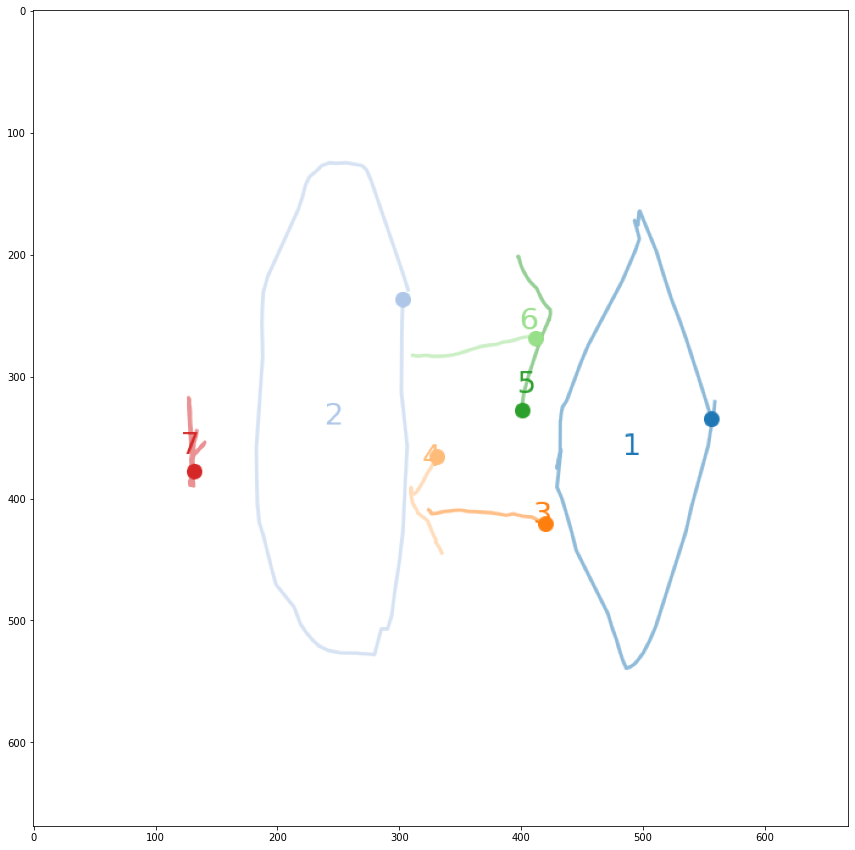

In [28]:
npfig, fig, _, _ = transform_strokes_to_image(batch_stroke.detach().cpu(), draw_seq_len, batch_start_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)
plt.figure(figsize = (15,15))
plt.imshow(npfig)

In [14]:
pos_model_inputs = torch.cat([sampled_input_emb, sampled_input_start_pos], dim = 2)

In [19]:
tgt_cond = sampled_target_start_pos.squeeze(dim = 1)

In [20]:
seq_len_inputs = sampled_seq_len_emb.int().to(cose.device)

In [21]:
seq_mask_rel = 1 - (torch.arange(seq_len_inputs.max().item()).to(cose.device)[None, :] < seq_len_inputs[:, None]).float()

In [20]:
loss_ae = -1*(logli_gmm_logsumexp(t_target_ink, ae_mu, ae_sigma, ae_pi)[t_target_ink.sum(dim=1) != 0].mean())
loss_pos_pred = -1*(logli_gmm_logsumexp(sampled_target_start_pos, pos_pred_mu, pos_pred_sigma, pos_pred_pi).mean())
loss_emb_pred = -1*(logli_gmm_logsumexp(sampled_target_emb, emb_pred_mu, emb_pred_sigma, emb_pred_pi).mean())

In [ ]:
n_diagram = 4

## Predicted through model

In [119]:
emb_ = sampled_input_emb[n_diagram][:sampled_seq_len_emb[n_diagram].int()].to(cose.device)
base_batch_start_pos = sampled_input_start_pos[n_diagram][:sampled_seq_len_emb[n_diagram].int()].to(cose.device)
base_draw_seq_len = np.array([50]*(emb_.size(0)))
base_batch_stroke = decode_sequence(cose.decoder, emb_, base_draw_seq_len, cose.device)

In [115]:
emb_ = emb_pred[n_diagram].unsqueeze(dim=0).to(cose.device)
predicted_batch_start_pos = out_pos_sample[n_diagram].unsqueeze(dim=0).to(cose.device)
predicted_draw_seq_len = np.array([50]*(emb_.size(0)))
predicted_batch_stroke = decode_sequence(cose.decoder, emb_, predicted_draw_seq_len, cose.device)

In [ ]:
batch_start_pos = torch.vstack([base_batch_start_pos,predicted_batch_start_pos])
batch_stroke = torch.vstack([base_batch_stroke,predicted_batch_stroke])
draw_seq_len = np.append(base_draw_seq_len, predicted_draw_seq_len)

In [120]:
npfig, fig, _, _ = transform_strokes_to_image(batch_stroke.detach().cpu(), draw_seq_len, batch_start_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

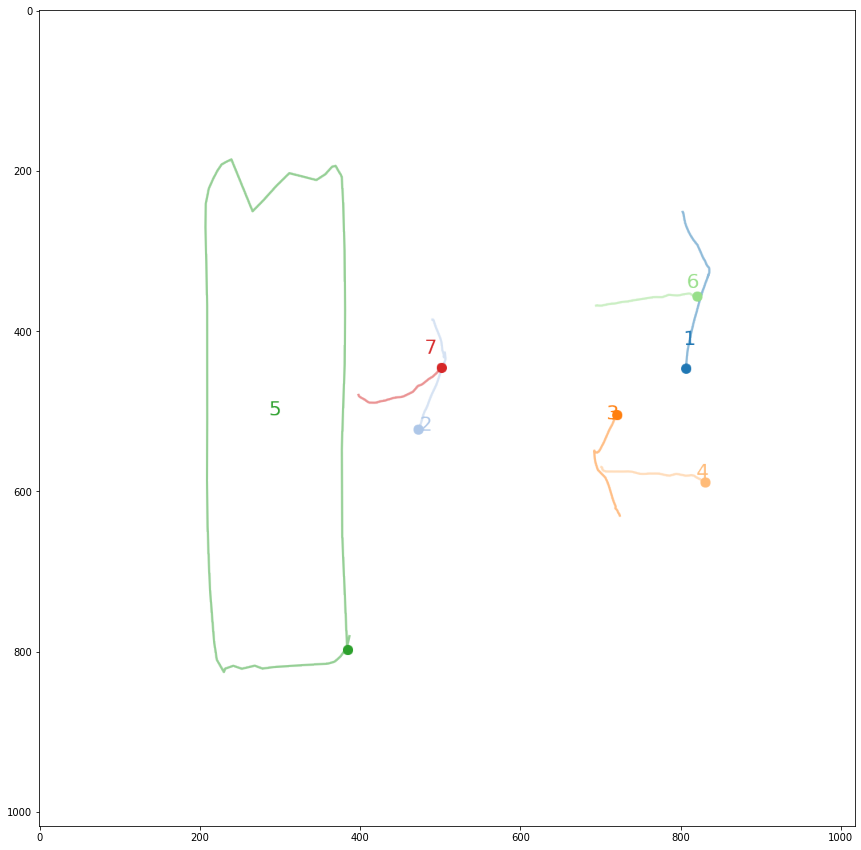

In [121]:
plt.figure(figsize = (15,15))
plt.imshow(npfig)

# Base

In [122]:
emb_ = sampled_input_emb[n_diagram][:sampled_seq_len_emb[n_diagram].int()].to(cose.device)
base_batch_start_pos = sampled_input_start_pos[n_diagram][:sampled_seq_len_emb[n_diagram].int()].to(cose.device)
base_draw_seq_len = np.array([50]*(emb_.size(0)))
base_batch_stroke = decode_sequence(cose.decoder, emb_, base_draw_seq_len, cose.device)

## Prediction

In [123]:
emb_ = sampled_target_emb[n_diagram].unsqueeze(dim=0).to(cose.device)
predicted_batch_start_pos = sampled_target_start_pos[n_diagram].unsqueeze(dim=0).to(cose.device)
predicted_draw_seq_len = np.array([50]*(emb_.size(0)))
predicted_batch_stroke = decode_sequence(cose.decoder, emb_, predicted_draw_seq_len, cose.device)

In [124]:
batch_start_pos = torch.vstack([base_batch_start_pos,predicted_batch_start_pos])
batch_stroke = torch.vstack([base_batch_stroke,predicted_batch_stroke])
draw_seq_len = np.append(base_draw_seq_len, predicted_draw_seq_len)

In [125]:
npfig, fig, _, _ = transform_strokes_to_image(base_batch_stroke.detach().cpu(), base_draw_seq_len, base_batch_start_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=base_batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

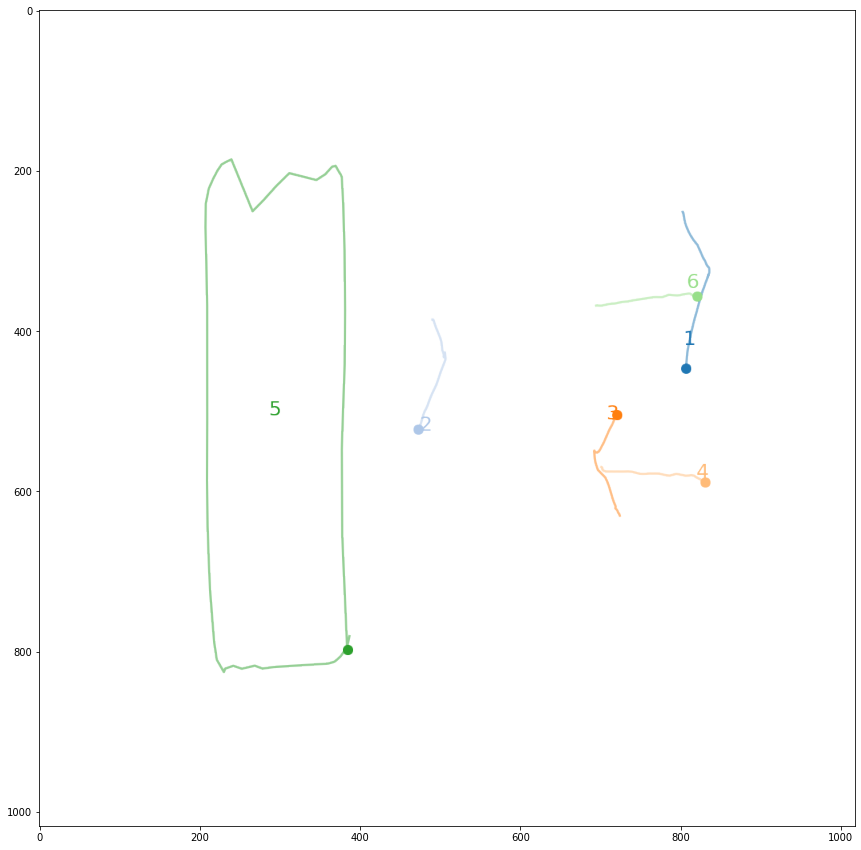

In [126]:
plt.figure(figsize = (15,15))
plt.imshow(npfig)

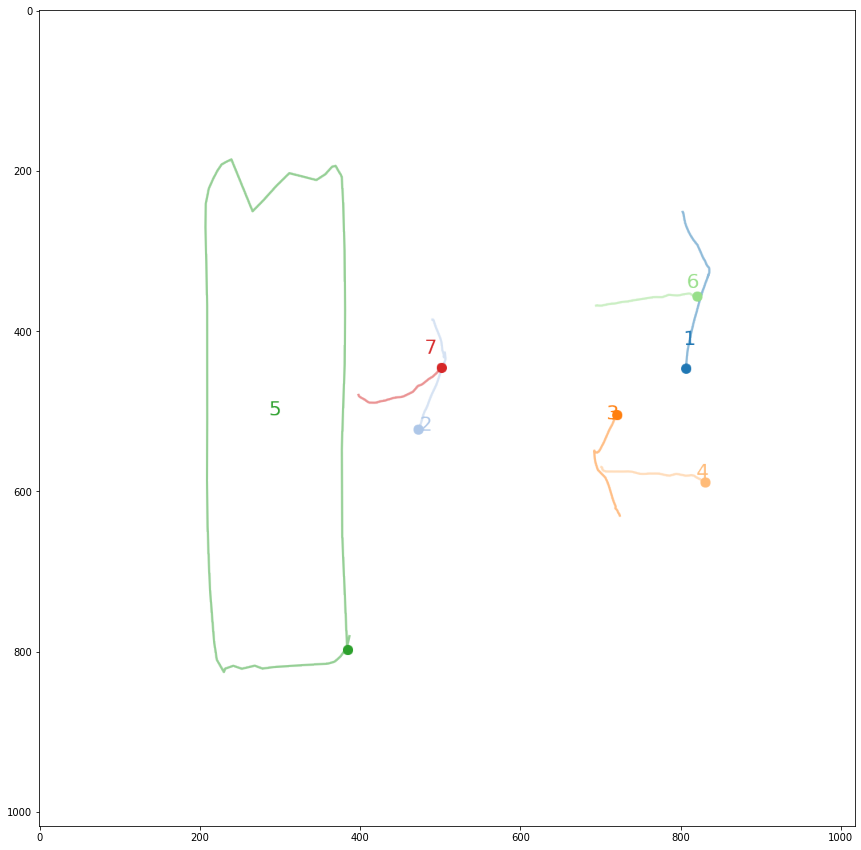

In [110]:
npfig, fig, _, _ = transform_strokes_to_image(batch_stroke.detach().cpu(), draw_seq_len, batch_start_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)
plt.figure(figsize = (15,15))
plt.imshow(npfig)

In [26]:
emb_.shape

torch.Size([1, 8])

In [17]:
sampled_target_emb.shape

torch.Size([1024, 8])

In [16]:
sampled_target_start_pos.shape

torch.Size([1024, 2])

In [18]:
sampled_seq_len_emb

tensor([7., 7., 7.,  ..., 5., 5., 5.])

In [13]:
sampled_input_start_pos.shape

torch.Size([1024, 7, 2])

In [14]:
sampled_input_emb.shape

torch.Size([1024, 7, 8])